In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
filename = 'data_evaluacion.csv'
#filename='data.csv'
df = pd.read_csv(filename)
print (df.shape)
df.head(5)

(48841, 15)


,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
df.nunique()

39                  74
State-gov            9
77516            28522
Bachelors           16
13                  16
Never-married        7
Adm-clerical        15
Not-in-family        6
White                5
Male                 2
2174               123
0                   99
40                  96
United-States       42
<=50K                2
dtype: int64

In [4]:
#Dar nombres a las columnas
nombre_columna = ['edad', 'empleador_tipo', 'peso', 'educacion', 'numero_educacion', 'estado_civil', 
                'ocupacion', 'relacion', 'raza', 'sexo', 'ganancia', 'perdida', 
                'horas_semana', 'pais_natal', 'ingresos']

df.columns=nombre_columna


In [5]:
df.nunique()

edad                   74
empleador_tipo          9
peso                28522
educacion              16
numero_educacion       16
estado_civil            7
ocupacion              15
relacion                6
raza                    5
sexo                    2
ganancia              123
perdida                99
horas_semana           96
pais_natal             42
ingresos                2
dtype: int64

In [6]:
#Ver si existen datos nulos
df.isnull().sum()

edad                0
empleador_tipo      0
peso                0
educacion           0
numero_educacion    0
estado_civil        0
ocupacion           0
relacion            0
raza                0
sexo                0
ganancia            0
perdida             0
horas_semana        0
pais_natal          0
ingresos            0
dtype: int64

In [27]:
df.head(4)

,edad,empleador_tipo,peso,educacion,numero_educacion,estado_civil,ocupacion,relacion,raza,sexo,ganancia,perdida,horas_semana,pais_natal,ingresos
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [20]:
#Dividir las variables x y y

x = df.drop('ingresos', axis=1)
y = df['ingresos']


In [35]:
# Definir características numéricas y categóricas
numeric_features = ['edad', 'peso', 'numero_educacion', 'ganancia', 'perdida', 'horas_semana']
categorical_features = ['empleador_tipo', 'educacion', 'estado_civil', 'ocupacion', 'relacion',
                        'raza', 'sexo', 'pais_natal']

In [36]:

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [37]:
# Crear el pipeline con el preprocesador y el modelo KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [39]:
# Dividir el conjunto de datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)


In [41]:
# Parámetros para la validación cruzada
nFolds = 5
kf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=0)
nVecinos = range(1, 16)

In [42]:
# Matriz para almacenar las precisiones
accMatriz = np.zeros((nFolds, len(nVecinos)))

In [43]:
# Validación cruzada
for j, n in enumerate(nVecinos):
    knn_pipeline.set_params(classifier__n_neighbors=n)
    for i, (idxTrain, idxVal) in enumerate(kf.split(x_train, y_train)):
        Xt, yt = x_train.iloc[idxTrain], y_train.iloc[idxTrain]
        Xv, yv = x_train.iloc[idxVal], y_train.iloc[idxVal]
        knn_pipeline.fit(Xt, yt)
        accMatriz[i, j] = knn_pipeline.score(Xv, yv)

In [44]:
# Calcular el promedio y la desviación estándar de las precisiones
accVector = np.mean(accMatriz, axis=0)
accStd = np.std(accMatriz, axis=0)


In [45]:
# Valor óptimo de n_neighbors
idx = np.argmax(accVector)
nOpt = nVecinos[idx]

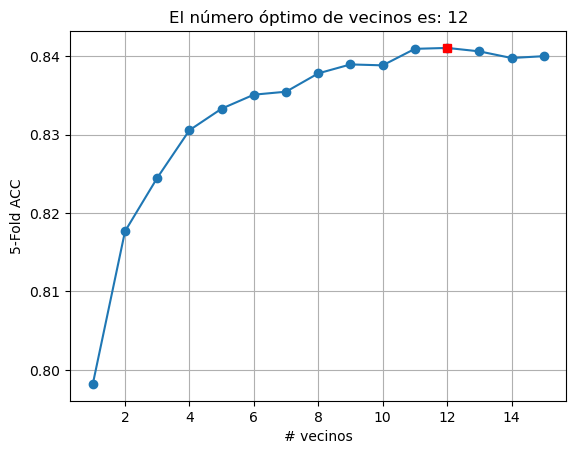

In [46]:
# Graficar los resultados
plt.plot(nVecinos, accVector, '-o')
plt.plot(nVecinos[idx], accVector[idx], 'rs')
plt.title('El número óptimo de vecinos es: %d' % nOpt)
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()

In [47]:
# Crear el pipeline con el preprocesador y el modelo KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=12))
])

In [50]:
knn_pipeline.fit(x_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['edad', 'peso',
                                                   'numero_educacion',
                                                   'ganancia', 'perdida',
                                                   'horas_semana']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['empleador_tipo',
                                                   'educacion', 'estado_civil',
                                                   'ocupacion', 'relacion',
                                                   'raza', 'sexo',
                                                   'pais_natal'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=12))])

In [51]:
y_pred = knn_pipeline.predict(x_test)

In [52]:
# Reporte de clasificación
report = classification_report(y_test, y_pred)
print(report)
# Evaluar el modelo
score = knn_pipeline.score(x_test, y_test)
print(f'Accuracy: {score}')

              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     11147
        >50K       0.73      0.58      0.64      3506

    accuracy                           0.85     14653
   macro avg       0.80      0.75      0.77     14653
weighted avg       0.84      0.85      0.84     14653

Accuracy: 0.8467208080256603


<Figure size 5000x2000 with 0 Axes>

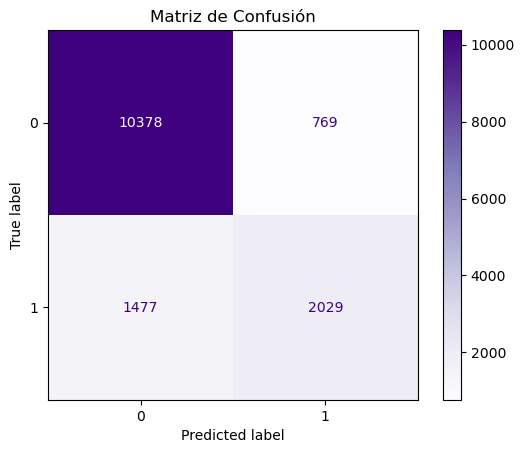

In [53]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
import matplotlib.ticker as ticker
plt.figure(figsize=(50, 20))  
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Purples, values_format='d') 
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Matriz de Confusión')
plt.show()

In [40]:
# Reporte de clasificación
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       <=50K       0.86      0.94      0.90     11147
        >50K       0.73      0.50      0.60      3506

    accuracy                           0.84     14653
   macro avg       0.79      0.72      0.75     14653
weighted avg       0.83      0.84      0.83     14653



## Bibliografias
### Shafi, A. (2024, March 12). Clasificación K vecinos más próximos (KNN) con scikit-learn. https://www.datacamp.com/es/tutorial/k-nearest-neighbor-classification-scikit-learn

### Arya, N. (n.d.). K-nearest neighbors in Scikit-learn - KDnuggets. KDnuggets. https://www.kdnuggets.com/2022/07/knearest-neighbors-scikitlearn.html